In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
sys.path.append('/content/drive/MyDrive/HW3')

Mounted at /content/drive


In [36]:

import torch
import torchvision
from engine import train_one_epoch, evaluate
import utils
import transforms as T
from pascal_dataset import PASCALDataset

def get_model(num_classes):
    # Load the pre-trained Faster R-CNN model and modify the output layer
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

def get_transform(train):
    # Define data augmentation transforms for training and testing datasets
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# Set the device for training and testing
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Define the training and testing datasets
train_dataset = PASCALDataset('/content/drive/MyDrive/HW3/PASCAL/train')
test_dataset = PASCALDataset('/content/drive/MyDrive/HW3/PASCAL/val')

# Define the data loaders for training and testing
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=utils.collate_fn)

# Define the Faster R-CNN model and move it to the device
num_classes = 6
model = get_model(num_classes)
model.to(device)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. Yo

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [37]:

# Define the optimizer and the learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    # Train for one epoch, printing every 50 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)

    # Evaluate the model on the testing dataset
    evaluate(model, data_loader_test, device=device)



Epoch: [0]  [  0/501]  eta: 0:08:06  lr: 0.000003  loss: 2.1097 (2.1097)  loss_classifier: 1.8840 (1.8840)  loss_box_reg: 0.2197 (0.2197)  loss_objectness: 0.0030 (0.0030)  loss_rpn_box_reg: 0.0030 (0.0030)  time: 0.9711  data: 0.3340  max mem: 4303
Epoch: [0]  [ 50/501]  eta: 0:04:41  lr: 0.000103  loss: 0.6865 (1.3031)  loss_classifier: 0.3547 (0.9896)  loss_box_reg: 0.2304 (0.2877)  loss_objectness: 0.0060 (0.0091)  loss_rpn_box_reg: 0.0115 (0.0168)  time: 0.6091  data: 0.0107  max mem: 4303
Epoch: [0]  [100/501]  eta: 0:04:01  lr: 0.000203  loss: 0.5055 (1.0009)  loss_classifier: 0.1940 (0.6418)  loss_box_reg: 0.2576 (0.3260)  loss_objectness: 0.0056 (0.0157)  loss_rpn_box_reg: 0.0109 (0.0173)  time: 0.5966  data: 0.0098  max mem: 4303
Epoch: [0]  [150/501]  eta: 0:03:31  lr: 0.000303  loss: 0.5244 (0.8594)  loss_classifier: 0.1982 (0.5055)  loss_box_reg: 0.2951 (0.3224)  loss_objectness: 0.0024 (0.0144)  loss_rpn_box_reg: 0.0098 (0.0171)  time: 0.6094  data: 0.0098  max mem: 4303


5


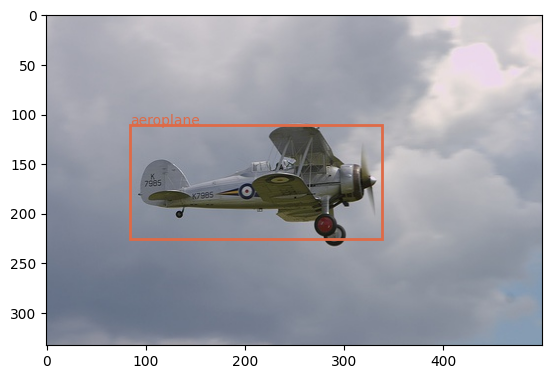

In [39]:
import torch
import torchvision
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the pre-trained Faster R-CNN model and the class labels
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#model = get_model(num_classes)
#model.to(device)
#model.eval()
model.eval()
model.to(torch.device('cpu'))
labels = ('background','people' , 'bicycle', 'car','motor' ,'aeroplane' )

# Load a sample image from file
image_path = '/content/drive/MyDrive/HW3/PASCAL/test/Images/2008_007397.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the image to a tensor and normalize it
image = image.astype(np.float32) / 255.0
image = torch.from_numpy(image).permute(2, 0, 1)

# Run inference on the image using the Faster R-CNN model
with torch.no_grad():
    prediction = model(image.unsqueeze(0))[0]

# Draw bounding boxes for each detected object in the image
fig, ax = plt.subplots(1)
ax.imshow(image.permute(1, 2, 0))
for i in range(len(prediction['boxes'])):
    box = prediction['boxes'][i].cpu().numpy().astype(int)
    label = prediction['labels'][i].cpu().numpy()
    color = np.random.rand(3)
    rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    if label>6:
        continue
    print(label)
    ax.text(box[0], box[1], labels[label], fontsize=10, color=color)
plt.show()


3
3
1
3
1
3


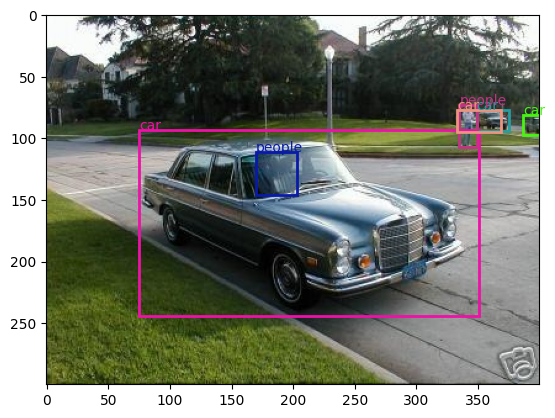

In [38]:
import torch
import torchvision
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the pre-trained Faster R-CNN model and the class labels
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#model = get_model(num_classes)
#model.to(device)
#model.eval()
model.eval()
model.to(torch.device('cpu'))
labels = ('background','people' , 'bicycle', 'car','motor' ,'aeroplane' )

# Load a sample image from file
image_path = '/content/drive/MyDrive/HW3/PASCAL/test/Images/2008_006800.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the image to a tensor and normalize it
image = image.astype(np.float32) / 255.0
image = torch.from_numpy(image).permute(2, 0, 1)

# Run inference on the image using the Faster R-CNN model
with torch.no_grad():
    prediction = model(image.unsqueeze(0))[0]

# Draw bounding boxes for each detected object in the image
fig, ax = plt.subplots(1)
ax.imshow(image.permute(1, 2, 0))
for i in range(len(prediction['boxes'])):
    box = prediction['boxes'][i].cpu().numpy().astype(int)
    label = prediction['labels'][i].cpu().numpy()
    color = np.random.rand(3)
    rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    if label>6:
        continue
    print(label)
    ax.text(box[0], box[1], labels[label], fontsize=10, color=color)
plt.show()


3
3
1
3


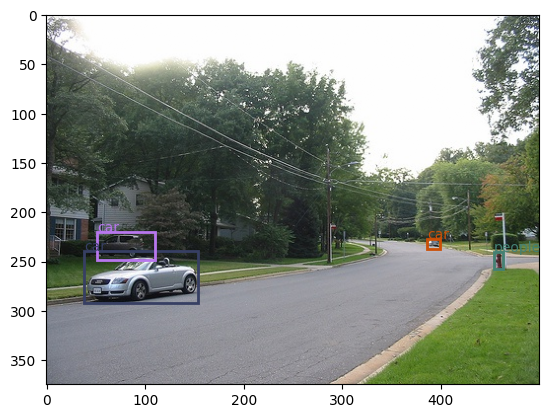

In [40]:
import torch
import torchvision
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the pre-trained Faster R-CNN model and the class labels
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#model = get_model(num_classes)
#model.to(device)
#model.eval()
model.eval()
model.to(torch.device('cpu'))
labels = ('background','people' , 'bicycle', 'car','motor' ,'aeroplane' )

# Load a sample image from file
image_path = '/content/drive/MyDrive/HW3/PASCAL/test/Images/2008_006417.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the image to a tensor and normalize it
image = image.astype(np.float32) / 255.0
image = torch.from_numpy(image).permute(2, 0, 1)

# Run inference on the image using the Faster R-CNN model
with torch.no_grad():
    prediction = model(image.unsqueeze(0))[0]

# Draw bounding boxes for each detected object in the image
fig, ax = plt.subplots(1)
ax.imshow(image.permute(1, 2, 0))
for i in range(len(prediction['boxes'])):
    box = prediction['boxes'][i].cpu().numpy().astype(int)
    label = prediction['labels'][i].cpu().numpy()
    color = np.random.rand(3)
    rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    if label>6:
        continue
    print(label)
    ax.text(box[0], box[1], labels[label], fontsize=10, color=color)
plt.show()


In [ ]:
import torch
import torchvision
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the pre-trained Faster R-CNN model and the class labels
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
labels = ('background','people' , 'bicycle', 'car','motor' ,'aeroplane' )

# Load a sample image from file
image_path = '/path/to/image.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the image to a tensor and normalize it
image = image.astype(np.float32) / 255.0
image = torch.from_numpy(image).permute(2, 0, 1)

# Define the real bounding boxes and labels for the image
real_boxes = torch.tensor([[50, 100, 150, 200], [250, 300, 350, 400]])
real_labels = torch.tensor([1, 3])

# Run inference on the image using the Faster R-CNN model
model.eval()
with torch.no_grad():
    prediction = model(image.unsqueeze(0))[0]

# Draw bounding boxes for each detected object in the image
fig, ax = plt.subplots(1)
ax.imshow(image.permute(1, 2, 0))
for i in range(len(prediction['boxes'])):
    box = prediction['boxes'][i].cpu().numpy().astype(int)
    label = prediction['labels'][i].cpu().numpy()
    color = np.random.rand(3)
    rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    if label>6:
        continue
    ax.text(box[0], box[1], labels[label], fontsize=10, color=color)

# Draw bounding boxes for the real objects in the image
for i in range(len(real_boxes)):
    box = real_boxes[i].numpy().astype(int)
    label = real_labels[i].numpy()
    color = 'red'
    rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    ax.text(box[0], box[1], labels[label], fontsize=10, color=color)

plt.show()


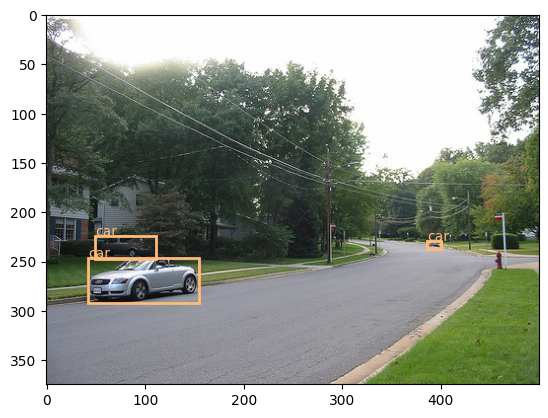

In [57]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import scipy.io

# define label names
labels = ('background','people' , 'bicycle', 'car','motor' ,'aeroplane' )

# load image
image_path = '/content/drive/MyDrive/HW3/PASCAL/test/Images/2008_006417.jpg'
image = plt.imread(image_path)

# load bbox and label
bbox_path = '/content/drive/MyDrive/HW3/PASCAL/test/BBox/2008_006417_bbox.mat'
bbox_mat = scipy.io.loadmat(bbox_path)
bbox = bbox_mat['bboxes']

label_path = '/content/drive/MyDrive/HW3/PASCAL/test/Labels/2008_006417_label.mat'
label_mat = scipy.io.loadmat(label_path)
label = label_mat['labels']
# draw bounding boxes on image
fig, ax = plt.subplots(1)
ax.imshow(image)


for i in range(len(bbox)):
    box = bbox[i].astype(int)
    box[2:] -= box[:2]  # convert from [x1, y1, x2, y2] to [x1, y1, w, h]
    cls = int(label[0][i])
    color = plt.cm.tab20(cls)
    rect = plt.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    ax.text(box[0], box[1], labels[cls], fontsize=10, color=color)

plt.show()


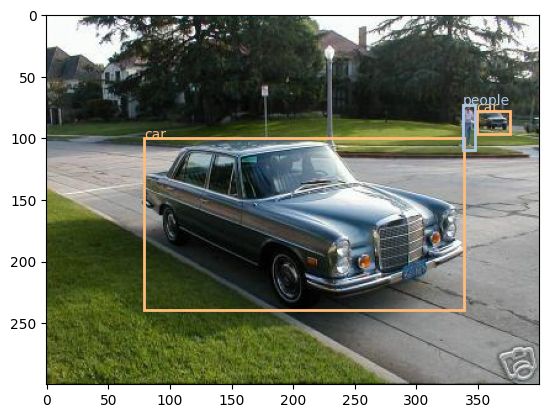

In [58]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import scipy.io

# define label names
labels = ('background','people' , 'bicycle', 'car','motor' ,'aeroplane' )

# load image
image_path = '/content/drive/MyDrive/HW3/PASCAL/test/Images/2008_006800.jpg'
image = plt.imread(image_path)

# load bbox and label
bbox_path = '/content/drive/MyDrive/HW3/PASCAL/test/BBox/2008_006800_bbox.mat'
bbox_mat = scipy.io.loadmat(bbox_path)
bbox = bbox_mat['bboxes']

label_path = '/content/drive/MyDrive/HW3/PASCAL/test/Labels/2008_006800_label.mat'
label_mat = scipy.io.loadmat(label_path)
label = label_mat['labels']
# draw bounding boxes on image
fig, ax = plt.subplots(1)
ax.imshow(image)


for i in range(len(bbox)):
    box = bbox[i].astype(int)
    box[2:] -= box[:2]  # convert from [x1, y1, x2, y2] to [x1, y1, w, h]
    cls = int(label[0][i])
    color = plt.cm.tab20(cls)
    rect = plt.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    ax.text(box[0], box[1], labels[cls], fontsize=10, color=color)

plt.show()


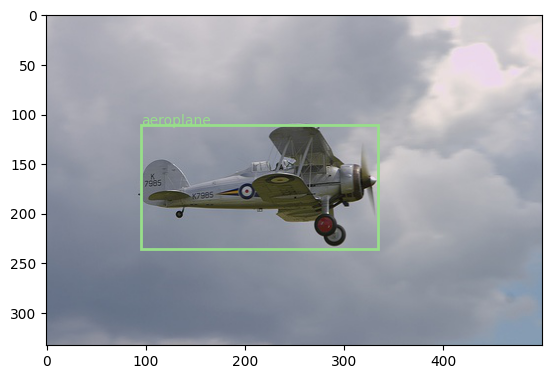

In [59]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import scipy.io

# define label names
labels = ('background','people' , 'bicycle', 'car','motor' ,'aeroplane' )

# load image
image_path = '/content/drive/MyDrive/HW3/PASCAL/test/Images/2008_007397.jpg'
image = plt.imread(image_path)

# load bbox and label
bbox_path = '/content/drive/MyDrive/HW3/PASCAL/test/BBox/2008_007397_bbox.mat'
bbox_mat = scipy.io.loadmat(bbox_path)
bbox = bbox_mat['bboxes']

label_path = '/content/drive/MyDrive/HW3/PASCAL/test/Labels/2008_007397_label.mat'
label_mat = scipy.io.loadmat(label_path)
label = label_mat['labels']
# draw bounding boxes on image
fig, ax = plt.subplots(1)
ax.imshow(image)


for i in range(len(bbox)):
    box = bbox[i].astype(int)
    box[2:] -= box[:2]  # convert from [x1, y1, x2, y2] to [x1, y1, w, h]
    cls = int(label[0][i])
    color = plt.cm.tab20(cls)
    rect = plt.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    ax.text(box[0], box[1], labels[cls], fontsize=10, color=color)

plt.show()
